4He Groundstate and a, beta, gamma optimization

In [19]:
# Packages
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [21]:
#parameters
hbar2div2m = 20.74  # MeV * fm^2

In [23]:
# Define the inter-nucleon potential function
@njit
def potential(r2):
    return (1000.0 * np.exp(-3.0 * r2) 
            - 163.35 * np.exp(-1.05 * r2) 
            - 83.0 * np.exp(-0.8 * r2) 
            - 21.5 * np.exp(-0.6 * r2) 
            - 11.5 * np.exp(-0.4 * r2))

In [25]:
# Trial wave function for 4He
@njit
def trial_wave_function(positions, a, beta, gamma):
    n_particles = positions.shape[0]
    psi = 1.0
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r2 = np.sum((positions[i] - positions[j]) ** 2)
            correlation = np.exp(-gamma * r2) - a * np.exp(-(beta + gamma) * r2)
            psi *= correlation
    return psi

In [27]:
# Local energy calculation
@njit
def local_energy(positions, a, beta, gamma):
    n_particles = positions.shape[0]
    # Potential part
    V = 0.0
    for i in range(n_particles):
        for j in range(i + 1, n_particles):
            r2 = np.sum((positions[i] - positions[j]) ** 2)
            V += potential(r2)

    # Kinetic energy part
    psi = trial_wave_function(positions, a, beta, gamma)
    grad_psi = 0.0 # Initializing wave function gradient
    delta = 1e-5  # Delta size for kinetic energy approximate calculation

    # Evaluating psi in two points and take the difference
    for i in range(n_particles):
        for j in range(3):  # They are 3D coordinates
            positions[i, j] += delta
            psi_plus = trial_wave_function(positions, a, beta, gamma)
            positions[i, j] -= 2 * delta
            psi_minus = trial_wave_function(positions, a, beta, gamma)
            positions[i, j] += delta  # Restore original position
            
            grad_psi += (psi_plus - 2 * psi + psi_minus) / (delta ** 2)
    
    kinetic_energy = -hbar2div2m * grad_psi / psi
    return kinetic_energy + V

In [29]:
# Main Variational Monte Carlo function with parameter optimization
@njit
def variational_monte_carlo(n_particles=4, n_steps=1000, thermalization_steps=200, a=0.1, beta=0.1, gamma=0.1):
    positions = np.random.normal(0, 5, (n_particles, 3))  # Random initial positions
    energy_samples = []

    # Thermalization phase (accepted steps without recording the resulting energy)
    for _ in range(thermalization_steps):
        # Proposing new positions
        new_positions = positions + np.random.normal(0, 0.5, positions.shape)
        psi_old = trial_wave_function(positions, a, beta, gamma)
        psi_new = trial_wave_function(new_positions, a, beta, gamma)
        
        # Define the metropolis acceptance condition
        acceptance_ratio = (psi_new / psi_old) ** 2
        if np.random.rand() < acceptance_ratio:
            positions = new_positions  # Accepting step
    
    # Main sampling phase
    for step in range(n_steps):
        # Proposing new positions
        new_positions = positions + np.random.normal(0, 0.5, positions.shape)
        psi_old = trial_wave_function(positions, a, beta, gamma)
        psi_new = trial_wave_function(new_positions, a, beta, gamma)
        
        # Define the metropolis acceptance condition
        acceptance_ratio = (psi_new / psi_old) ** 2
        if np.random.rand() < acceptance_ratio:
            positions = new_positions  # Accepting step
        
        E_local = local_energy(positions, a, beta, gamma)
        energy_samples.append(E_local)

    # Converting energy_samples to a NumPy array, for compatibility issues with numba.
    energy_samples = np.array(energy_samples)

    # Computing the mean energy - and it's variance - over all the VMC steps
    mean_energy = np.mean(energy_samples)
    std_error = np.std(energy_samples) / np.sqrt(n_steps)
    
    return mean_energy, std_error


In [31]:
# Optimizing alpha and computing the minimum local energy

# Range of parameters
a_values = np.linspace(0.1, 1.0, 10)
beta_values = np.linspace(0.5, 3.0, 15)
gamma_values = np.linspace(0.01, 0.1, 10)

best_energy = float('inf')
best_params = (0, 0, 0)
energy_results = []

for a in a_values:
    for beta in beta_values:
        for gamma in gamma_values:
            mean_energy, std_error = variational_monte_carlo(n_particles=4, n_steps=1000, thermalization_steps=300, a=a, beta=beta, gamma=gamma)
            energy_results.append((a, beta, gamma, mean_energy))
            if mean_energy < best_energy:
                best_energy = mean_energy
                best_params = (a, beta, gamma)

In [32]:
# Print the best parameters and corresponding energy
print("Optimal parameters (a, beta, gamma):", best_params)
print("Estimated ground state energy:", best_energy, "MeV")

Optimal parameters (a, beta, gamma): (0.7000000000000001, 2.4642857142857144, 0.08)
Estimated ground state energy: -31.38576968436365 MeV


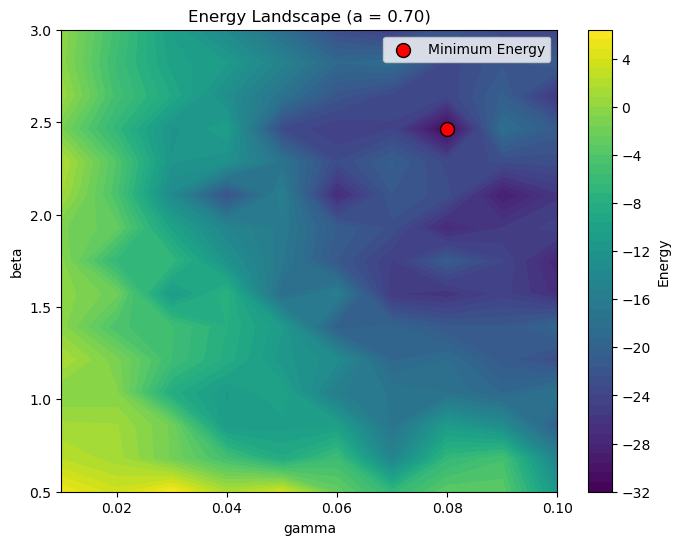

In [33]:
# Set a_fixed to the best value found for a
a_fixed = best_params[0]

# Filter results for fixed a
filtered_results = [(beta, gamma, energy) for a, beta, gamma, energy in energy_results if np.isclose(a, a_fixed)]

# Prepare data for heatmap
beta_vals = np.unique([beta for beta, gamma, energy in filtered_results])
gamma_vals = np.unique([gamma for beta, gamma, energy in filtered_results])
energy_grid = np.array([energy for beta, gamma, energy in sorted(filtered_results, key=lambda x: (x[0], x[1]))])
energy_grid = energy_grid.reshape(len(beta_vals), len(gamma_vals))

# Plot heatmap
plt.figure(figsize=(8, 6))
plt.contourf(gamma_vals, beta_vals, energy_grid, levels=50, cmap='viridis')
plt.colorbar(label='Energy')

# Highlight the minimum energy point
beta_min, gamma_min = best_params[1], best_params[2]
plt.scatter(gamma_min, beta_min, color='red', s=100, edgecolor='black', label='Minimum Energy')

# Labeling axes and title
plt.xlabel('gamma')
plt.ylabel('beta')
plt.title(f'Energy Landscape (a = {a_fixed:.2f})')
plt.legend()
plt.show()